In [1]:
import os

os.environ['SNORKELDB'] = "postgresql://localhost:5432/snorkel?user=snorkel&password=snorkel12345"

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from snorkel import SnorkelSession

session = SnorkelSession()

In [3]:
from ksnorkel import KSUtils

train_sent, dev_sent, test_sent = KSUtils.split_sentences(session)
print("Amount of sentences: {} train, {} dev and {} test".format(len(train_sent), len(dev_sent), len(test_sent)))

Amount of docs: 9738
Document splitted: 3246 train, 3246 dev and 3246 test
Amount of sentences: 33895 train, 34340 dev and 34326 test


In [4]:
from snorkel.models import Candidate, candidate_subclass
from snorkel.candidates import PretaggedCandidateExtractor

ChemicalGeneInhibition = candidate_subclass('ChemicalGeneInhibition', ['chemical', 'gene'])


In [ ]:
from snorkel.models import Candidate, candidate_subclass
from snorkel.candidates import PretaggedCandidateExtractor

ChemicalGeneInhibition = candidate_subclass('ChemicalGeneInhibition', ['chemical', 'gene'])
candidate_gene_chemical_inhibit_extractor = PretaggedCandidateExtractor(ChemicalGeneInhibition, ['Chemical', 'Gene'])


for k, sents in enumerate([train_sent, dev_sent, test_sent]):
    candidate_gene_chemical_inhibit_extractor.apply(sents, split=k, clear=True)
    print("Number of candidates:", session.query(ChemicalGeneInhibition).filter(ChemicalGeneInhibition.split == k).count())

In [ ]:
import gzip
import re

ctd_chem_gene_inhib = set()
i = 0
with gzip.open('data/CTD_chem_gene_ixns.tsv.gz','r') as f:
    for l in f:
        line = str(l).replace('b\'', '').replace('\\n\'', '').replace('\\r','')
        # skip comments
        if line.startswith('#'):
            continue
        #print(line)
        components = line.split('\\t')    
        
        # add MESH:
        if not components[1].startswith('MESH:'):
            components[1] = "MESH:" + components[1]
            
        desc = components[8].lower()
        if 'inhibit' not in desc:
            continue
        descTyp = components[9]
        if 'decreases' not in descTyp:
            continue
        
        che_name = components[0].replace('b\"','').replace('(','\(').replace(')','\)').lower()
        regex = '{}[^\]\[]+inhibit'.format(che_name)
        regex2 = '{}[^\]\[]+decreased activity'.format(che_name)
        if re.search(regex, desc) == None and re.search(regex2, desc) == None:
            #print(components[0])
            #print(desc)
            #print()
            continue
        
        chemical = components[1]
        gene = components[4]
        key = frozenset((chemical, gene))
        ctd_chem_gene_inhib.add(key)
        i += 1

    
print('{} chemical-gene assocations read from ChG-CTD_chem_gene_ixns'.format(len(ctd_chem_gene_inhib)))
#240349
def cand_in_chemical_gene_inhibitions(c):
    key = frozenset((c.chemical_cid, c.gene_cid))
    if key in ctd_chem_gene_inhib:
    #    print(key)
        return 1
    return -1

In [ ]:
from ksnorkel import KSUtils

KSUtils.add_gold_labels_for_candidates(session, ChemicalGeneInhibition, cand_in_chemical_gene_inhibitions)

In [5]:
import re
from snorkel.lf_helpers import (
    get_tagged_text,
    rule_regex_search_tagged_text,
    rule_regex_search_btw_AB,
    rule_regex_search_btw_BA,
    rule_regex_search_before_A,
    rule_regex_search_before_B
)




# List to parenthetical
def ltp(x):
    return '(' + '|'.join(x) + ')'



inhibition_samples = ["inhibitor", "inhibition", "auto-inhibition", 'inhibitory', 'suppression']


def LF_CG_AB_before_inhibition(c):
    return 1 if (re.search(r'{{A}}.{0,100}' + '{{B}}.{0,100}' + 'inhibition' , get_tagged_text(c), re.I) or
                re.search(r'{{B}}.{0,100}' + '{{A}}.{0,100}' + 'inhibition' , get_tagged_text(c), re.I)) else 0


def LF_CG_A_supressive_effect_B(c):
    return 1 if  re.search(r'{{A}}.{0,100} supressive'+ '.{0,100} effect .{0,100}' + '{{A}}' , get_tagged_text(c), re.I) else 0


def LF_CG_AB_after_inhibition(c):
    return 1 if (rule_regex_search_before_A(c,  ltp(inhibition_samples) + '.{0,100}', 1) and
                  rule_regex_search_before_B(c, ltp(inhibition_samples) + '.{0,100}', 1)) else 0

def LF_CG_A_inhibition_B_far(c):
    return rule_regex_search_btw_AB(c, '.{100,500}' + ltp(inhibition_samples) + '.{100,500}', -1) 

def LF_CG_B_inhibition_A_far(c):
    return rule_regex_search_btw_BA(c, '.{100,500}' + ltp(inhibition_samples) + '.{100,500}', -1)

def LF_CG_A_inhibition_B(c):
    return rule_regex_search_btw_AB(c, '.{0,100}' + ltp(inhibition_samples) + '.{0,100}', 1) 

def LF_CG_B_inhibition_A(c):
    return rule_regex_search_btw_BA(c, '.{0,100}' + ltp(inhibition_samples) + '.{0,100}', 1)

def LG_CG_inhibition_before_B_near(c):
    return rule_regex_search_before_B(c, ltp(inhibition_samples) + '.{0,100}', 1)
 
def LG_CG_inhibition_before_B_far(c):
    return rule_regex_search_before_B(c, ltp(inhibition_samples) + '.{100,2000}', -1)


inhibits_samples = ["inhibit", 'decrease', 'degrees', 'suppress', 'alleviate', 'reduce']

def LF_CG_A_inhibitis_B(c):
    return rule_regex_search_btw_AB(c, '.{0,100}' + ltp(inhibits_samples) + '.{0,100}', 1) 

def LF_CG_A_inhibitis_B_close(c):
    return rule_regex_search_btw_AB(c, '.{0,50}' + ltp(inhibits_samples) + '.{0,50}', 1) 


not_samples = ['no', 'not']

def LF_CG_A_not_inhibitis_B(c):
    return rule_regex_search_btw_AB(c, '.{0,100}' + ltp(not_samples) + '.{0,100}' + ltp(inhibits_samples) + '.{0,100}', -1) 


inhibited_samples = ["inhibited", 'decreased', 'degreesed', 'suppressed', 'alleviated', 'reduced']

def LF_CG_B_inhibited_A(c):
    return rule_regex_search_btw_BA(c, '.{0,100}' + ltp(inhibited_samples) + '.{0,100}', 1) 


inhib_all_words = []
inhib_all_words.extend(inhibition_samples)
inhib_all_words.extend(inhibits_samples)

def LF_CG_no_inhibition(c):
    return -1 if not re.search(r'' + ltp(inhib_all_words)  , get_tagged_text(c), re.I) else 0

metabol_samples = ['metabol', 'increase', 'stimulate', 'stimulating']

def LF_CG_A_metabol_B_in_sent(c):
    return rule_regex_search_btw_AB(c, '.{0,100}' + ltp(metabol_samples) + '.{0,100}', -1) 

def LF_CG_B_metabol_A_in_sent(c):
    return rule_regex_search_btw_AB(c, '.{0,100}' + ltp(metabol_samples) + '.{0,100}', -1) 

def LF_CG_metabol_in_sent(c):
    return -1 if re.search(r'' + ltp(metabol_samples)  , get_tagged_text(c), re.I) else 0


def LF_closer_chem(c):
    # Get distance between chemical and gene
    chem_start, chem_end = c.chemical.get_word_start(), c.chemical.get_word_end()
    gen_start, gen_end = c.gene.get_word_start(), c.gene.get_word_end()
    if gen_start < chem_start:
        dist = chem_start - gen_end
    else:
        dist = gen_start - chem_end
    # Try to find chemical closer than @dist/2 in either direction
    sent = c.get_parent()
    closest_other_chem = float('inf')
    for i in range(gen_end, min(len(sent.words), gen_end + dist // 2)):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Chemical' and cid != sent.entity_cids[chem_start]:
            return -1
    for i in range(max(0, gen_start - dist // 2), gen_start):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Chemical' and cid != sent.entity_cids[chem_start]:
            return -1
    return 0


def LF_closer_gene(c):
    # Get distance between chemical and gene
    chem_start, chem_end = c.chemical.get_word_start(), c.chemical.get_word_end()
    gen_start, gen_end = c.gene.get_word_start(), c.gene.get_word_end()
    if gen_start < chem_start:
        dist = chem_start - gen_end
    else:
        dist = gen_start - chem_end
    # Try to find gene closer than @dist/8 in either direction
    sent = c.get_parent()
    for i in range(chem_end, min(len(sent.words), chem_end + dist // 8)):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Gene' and cid != sent.entity_cids[gen_start]:
            return -1
    for i in range(max(0, chem_start - dist // 8), chem_start):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Gene' and cid != sent.entity_cids[gen_start]:
            return -1
    return 0

                

def LF_CG_metabol_between(c):
    # Get distance between chemical and disease
    chem_start, chem_end = c.chemical.get_word_start(), c.chemical.get_word_end()
    dis_start, dis_end = c.gene.get_word_start(), c.gene.get_word_end()
    if dis_start < chem_start:
        dist = chem_start - dis_end
    else:
        dist = dis_start - chem_end
    # Try to find metabol closer than @dist/2 in either direction
    sent = c.get_parent()
    closest_other_chem = float('inf')
    for i in range(dis_end, min(len(sent.words), dis_end + dist // 2)):
        if re.search(r'' + ltp(metabol_samples), sent.words[i], re.I):
            return -1
    for i in range(max(0, dis_start - dist // 2), dis_start):
        if re.search(r'' + ltp(metabol_samples), sent.words[i], re.I):
            return -1
    return 0


    
LFs_DG = [
    LF_CG_AB_before_inhibition,
    LF_CG_AB_after_inhibition,
    LF_CG_A_supressive_effect_B,
    LF_CG_A_inhibition_B_far,
    LF_CG_B_inhibition_A_far,
    LF_CG_A_inhibition_B,
    LF_CG_B_inhibition_A,
    LG_CG_inhibition_before_B_near,
    LG_CG_inhibition_before_B_far,
    LF_CG_A_inhibitis_B,
    LF_CG_A_inhibitis_B_close,
    LF_CG_A_not_inhibitis_B,
    LF_CG_B_inhibited_A,  
    LF_CG_no_inhibition,
    LF_CG_A_metabol_B_in_sent,
    LF_CG_B_metabol_A_in_sent,
    LF_CG_metabol_in_sent,
    LF_closer_chem,
    LF_closer_gene,
    LF_CG_metabol_between
]

In [ ]:
def LF_in_CTD_chem_gene_inhibition(c):
    if cand_in_chemical_gene_inhibitions(c) == 1:
        return 1
    return -1

LFs_DG = [
    LF_in_CTD_chem_gene_inhibition    
]

In [6]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs_DG)
%time L_train = labeler.apply(lfs=LFs_DG, parallelism=10)
L_train


  0%|          | 0/18454 [00:00<?, ?it/s]

Clearing existing...
Running UDF...


100%|██████████| 18454/18454 [02:19<00:00, 132.22it/s]


CPU times: user 32.1 s, sys: 3.81 s, total: 35.9 s
Wall time: 2min 19s


<18454x19 sparse matrix of type '<class 'numpy.int64'>'
	with 28615 stored elements in Compressed Sparse Row format>

In [7]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_CG_AB_before_inhibition,0,0.010946,0.006286,0.004335
LF_CG_AB_after_inhibition,1,0.000000,0.000000,0.000000
LF_CG_A_supressive_effect_B,2,0.000000,0.000000,0.000000
LF_CG_A_inhibition_B_far,3,0.001897,0.001842,0.000000
LF_CG_B_inhibition_A_far,4,0.003631,0.003468,0.002384
LF_CG_A_inhibition_B,5,0.032026,0.031917,0.014794
LF_CG_B_inhibition_A,6,0.029750,0.014739,0.012789
LG_CG_inhibition_before_B_near,7,0.024818,0.016419,0.014577
LG_CG_inhibition_before_B_far,8,0.005148,0.004064,0.002168
LF_CG_A_inhibitis_B,9,0.106264,0.059933,0.042051


In [8]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_train, epochs=100, decay=0.95, step_size=0.1 / L_train.shape[0], reg_param=1e-6)

train_marginals = gen_model.marginals(L_train)

Inferred cardinality: 2


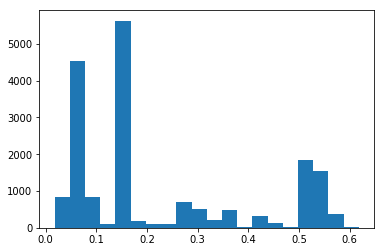

In [9]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [11]:
from snorkel.annotations import load_gold_labels

L_dev = labeler.apply_existing(split=1)
L_test = labeler.apply_existing(split=2)
L_gold_dev = load_gold_labels(session, annotator_name='gold',split=1)
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)


  0%|          | 3/16703 [00:00<10:20, 26.92it/s]

Clearing existing...
Running UDF...


  0%|          | 5/16881 [00:00<06:10, 45.50it/s]

Clearing existing...
Running UDF...


100%|██████████| 16881/16881 [03:09<00:00, 88.97it/s] 


In [ ]:
from snorkel.learning import GenerativeModel
from snorkel.learning import RandomSearch
from snorkel.learning.structure import DependencySelector


MAX_DEPS = 5

ds = DependencySelector()
deps = ds.select(L_train, threshold=0.1)
deps = set(list(deps)[0:min(len(deps), MAX_DEPS)])

print("Using {} dependencies".format(len(deps)))



# use random search to optimize the generative model
param_grid = {
    'step_size' : [1e-3, 1e-4, 1e-5, 1e-6],
    'decay'     : [0.9, 0.95],
    'epochs'    : [50,100,150],
    'reg_param' : [1e-3],
}

model_class_params = {'lf_propensity' : False }#, 'deps': deps}

searcher = RandomSearch(GenerativeModel, param_grid, L_train, n=10, model_class_params=model_class_params)
%time gen_model, run_stats = searcher.fit(L_dev, L_gold_dev) #, deps=deps)
run_stats



In [ ]:
train_marginals = gen_model.marginals(L_train)

In [ ]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [ ]:
from snorkel.annotations import save_marginals

dev_marginals = gen_model.marginals(L_dev)
_, _, _, _ = gen_model.error_analysis(session, L_dev, L_gold_dev)

%time save_marginals(session, L_train, train_marginals)

In [ ]:
tp, fp, tn, fn = gen_model.error_analysis(session, L_test, L_gold_test)

In [10]:
print("Load all ChemicalGeneInhibition candidates from db...")
train_cands = session.query(ChemicalGeneInhibition).filter(ChemicalGeneInhibition.split == 0).order_by(ChemicalGeneInhibition.id).all()
dev_cands   = session.query(ChemicalGeneInhibition).filter(ChemicalGeneInhibition.split == 1).order_by(ChemicalGeneInhibition.id).all()
test_cands  = session.query(ChemicalGeneInhibition).filter(ChemicalGeneInhibition.split == 2).order_by(ChemicalGeneInhibition.id).all()


all_cands = []
all_cands.extend(train_cands)
all_cands.extend(dev_cands)
all_cands.extend(test_cands)


print("{} {} {}".format(len(train_cands), len(dev_cands), len(test_cands)))
print("Amount of all candidates: {}".format(len(all_cands)))

Load all ChemicalGeneInhibition candidates from db...
18454 16703 16881
Amount of all candidates: 52038


In [12]:
from snorkel.learning.pytorch import LSTM
from snorkel.annotations import load_gold_labels

train_kwargs = {
    'lr':            0.0010,
    'embedding_dim': 50,
    'hidden_dim':    50,
    'n_epochs':      2,
    'dropout':       0.25,
    'rebalance':     0.0,
    'seed':          1701
}

lstm = LSTM(n_threads=10)
lstm.train(train_cands, train_marginals, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)

[LSTM] Training model
[LSTM] n_train=16699  #epochs=2  batch size=64


/home/kroll/.conda/envs/snorkel/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[LSTM] Epoch 1 (202.36s)	Average loss=0.503977	Dev F1=0.00
[LSTM] Epoch 2 (435.53s)	Average loss=0.465257	Dev F1=3.98
[LSTM] Training done (480.62s)


In [13]:

p, r, f1 = lstm.score(test_cands, L_gold_test)
print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

Prec: 0.165, Recall: 0.025, F1 Score: 0.043


In [14]:
tp, fp, tn, fn = lstm.error_analysis(session, test_cands, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.0246
Neg. class accuracy: 0.981
Precision            0.165
Recall               0.0246
F1                   0.0428
----------------------------------------
TP: 54 | FP: 273 | TN: 14411 | FN: 2143



In [15]:
lstm.save_marginals(session, all_cands)

Saved 52038 marginals


In [16]:
from snorkel.models.candidate import Marginal
from snorkel.models import Document, Sentence


print("Storing candidate labels into result file...")
amount_of_candidates = session.query(Candidate).count()
print("Amount of candidates: {}".format(amount_of_candidates))

all_sents = []
all_sents.extend(train_sent)
all_sents.extend(dev_sent)
all_sents.extend(test_sent)


Storing candidate labels into result file...
Amount of candidates: 52038


In [17]:
header_str = '{}\t{}\t{}\t{}\t{}\t{}\t{}'.format('sentence_id', 'cand_id', 'chemical_cid', 'chemical_span','gene_cid', 'gene_span', 'sentence')
%time KSUtils.save_binary_relation_confusion_matrix_as_tsv('results/chemical_gene_inhibition.tsv', session, all_cands, all_sents, header_str, 'chemical_cid', 'gene_cid')

Storing candidate labels into result file: results/chemical_gene_inhibition.tsv
Amount of candidates: 52038
Load mariginals from db...
Marginals loaded!
Load gold labels from db...
Gold labels loaded!
Start writing files...
Saved 1002 TP, 4733 FP, 40118 TN, 6185 FN facts in files.
CPU times: user 1min 57s, sys: 4.86 s, total: 2min 2s
Wall time: 2min 32s


In [ ]:
header_str = '{}\t{}\t{}\t{}\t{}\t{}\t{}'.format('document_id', 'sentence_id', 'cand_id','gene_cid', 'gene_span','chemical_cid', 'chemical_span')
%time KSUtils.save_binary_relation_as_tsv('results/chemical_gene_inhibition.tsv', session, all_cands, all_sents, header_str,'chemical_cid', 'gene_cid')

In [18]:
lstm.save("chemical_gene_inhibition.lstm")

[LSTM] Model saved as <chemical_gene_inhibition.lstm>
